4 seconds interval

$c(t)=\sin(5t)$



In [ ]:

# Plotting
plt.imshow(theta_dot, aspect='auto')
plt.title('sol')
plt.xlabel('space')
plt.ylabel('time')
plt.show()

# 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(x_eval, t_eval)
ax.plot_surface(X, Y, theta_dot, cmap='viridis')
ax.set_xlabel('space')
ax.set_ylabel('time')
ax.set_zlabel('solution')
plt.show()

# Plot residuals over time
plt.plot(t_eval, residuals)
plt.xlabel('Time')
plt.ylabel('Residual')
plt.title('Residuals over Time')
plt.show()


$$B * \nabla_{\theta} u \dot{\theta} = B * f$$

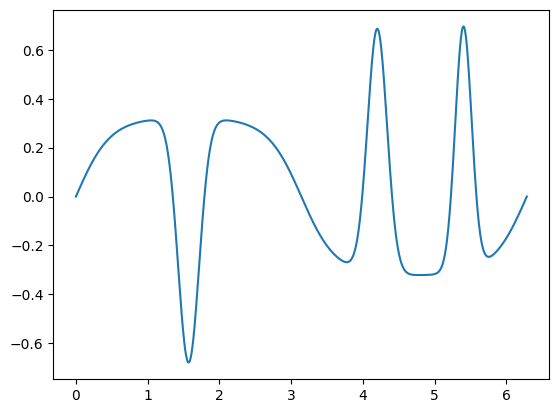

jit complied!
done!
Time: 0.0, Residual: 41.652793884277344
Time: 0.004999999888241291, Residual: 32.61362838745117
Time: 0.009999999776482582, Residual: 41.46242141723633
Time: 0.014999999664723873, Residual: 37.317081451416016
Time: 0.019999999552965164, Residual: 36.470855712890625
Time: 0.02499999850988388, Residual: 46.684600830078125
Time: 0.029999999329447746, Residual: 51.66942596435547
Time: 0.03500000014901161, Residual: 50.29998016357422
Time: 0.03999999910593033, Residual: 46.4176025390625
Time: 0.044999998062849045, Residual: 43.06062316894531
Time: 0.04999999701976776, Residual: 40.90879821777344
Time: 0.054999999701976776, Residual: 45.848548889160156
Time: 0.05999999865889549, Residual: 57.71914291381836
Time: 0.06499999761581421, Residual: 66.01041412353516
Time: 0.07000000029802322, Residual: 55.536659240722656
Time: 0.07499999552965164, Residual: 56.5953254699707
Time: 0.07999999821186066, Residual: 55.004520416259766
Time: 0.08500000089406967, Residual: 67.453926086

In [1]:
# B * \grad u \dot{\theta} = B * f
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import jit, vmap, grad
import jax.flatten_util
from time import time
import pandas as pd
import numpy as np

# High Speed Setting
n_x = 1000  # number of sample points in space
sub_sample = 100  # number of parameters to randomly sample
dt = 5e-3  # time step 
# set up time and space domain
Tend = 1.0
t_eval = jnp.linspace(0.0, Tend, int(Tend/dt) + 1)

dim = 1
A, B = 0, 2 * jnp.pi
x_eval = jnp.expand_dims(jnp.linspace(A, B, n_x), axis=-1)

from rsng.dnn import build_nn, init_net

key = jax.random.PRNGKey(1)
width = 25
depth = 7
period = 2 * jnp.pi

net = build_nn(width, depth, period)
u_scalar, theta_init, unravel = init_net(net, key, dim)

# used to take gradient and then squeeze
def gradsqz(f, *args, **kwargs):
    return lambda *fargs, **fkwargs: jnp.squeeze(grad(f, *args, **kwargs)(*fargs, **fkwargs))

# batch the function over X points
U = vmap(u_scalar, (None, 0))

# derivative with respect to theta
U_dtheta = vmap(grad(u_scalar), (None, 0))

# first spatial derivative
U_dx = vmap(gradsqz(u_scalar, 1), (None, 0))

# second spatial derivatives
U_ddx = vmap(gradsqz(gradsqz(u_scalar, 1), 1), (None, 0))

# load the parameters which fit initial condition
theta_0 = pd.read_pickle('./rsng/data/theta_init_ac.pkl')
theta_0 = jax.flatten_util.ravel_pytree(theta_0)[0]

# plot initial condition
plt.plot(x_eval, U(theta_0, x_eval))
plt.show()

########### Modified for linear advection equation
def rhs(t, theta):
    u = U(theta, x_eval)
    u_x = U_dx(theta, x_eval)
    #c = lambda t: jnp.sin(5 * t)
    #c = lambda t :1.0
    return -1 * u_x

def rhs_reparameterized(t, theta, key):
    key, _ = jax.random.split(key)
    J = U_dtheta(theta, x_eval)  # take the gradient with respect to the parameters
    B= jax.random.normal(key, (n_x, n_x))
    f = rhs(t, theta)  # compute f from rhs
    J = jnp.dot(B, J)
    S_t = jax.random.choice(key, len(theta), shape=(sub_sample,), replace=False)  # create random indices over the columns
    J = jnp.take(J, S_t, axis=1)  # subsample columns
    f = jnp.dot(B, f)
    
    # solve least squares problem on subsampled gradient
    theta_dot = jnp.linalg.lstsq(J, f, rcond=1e-4)[0]

    # check residual
    residual = jnp.linalg.norm(jnp.dot(J, theta_dot) - f)
    
    # go back into full parameter space, zero for non-sampled columns
    theta_dot = jnp.zeros(len(theta)).at[S_t].set(theta_dot)

    return theta_dot, residual

def odeint_rk4(fn, y0, t, key):
    "Adapted from: https://github.com/DifferentiableUniverseInitiative/jax_cosmo/blob/master/jax_cosmo/scipy/ode.py"
    def rk4(carry, t):
        y, t_prev, key = carry
        h = t - t_prev
        key, subkey = jax.random.split(key)

        k1, _ = fn(t_prev, y, subkey)
        k2, _ = fn(t_prev + h / 2, y + h * k1 / 2, subkey)
        k3, _ = fn(t_prev + h / 2, y + h * k2 / 2, subkey)
        k4, _ = fn(t, y + h * k3, subkey)

        y = y + 1.0 / 6.0 * h * (k1 + 2 * k2 + 2 * k3 + k4)
        return (y, t, key), y

    (yf, _, _), y = jax.lax.scan(rk4, (y0, jnp.array(t[0]), key), t)
    return y


def integrate(y0, t):
    return odeint_rk4(rhs_reparameterized, y0, t, key) 

# here we separate compile time from integration time
integrate_complied = jit(integrate).lower(theta_0, t_eval).compile() 
print('jit complied!')
time_start = time()
y = integrate_complied(theta_0, t_eval)
time_end = time()
print('done!')

steps = len(t_eval)
theta_dot = np.zeros((steps, len(x_eval)))
residuals = []
for i in range(steps):
    theta = y[i, :]
    theta_dot[i] = jnp.squeeze(U(theta, x_eval))
    _, residual = rhs_reparameterized(t_eval[i], theta, key)
    residual_value = jax.device_get(residual)
    residuals.append(residual_value)
    print(f"Time: {t_eval[i]}, Residual: {residual_value}")


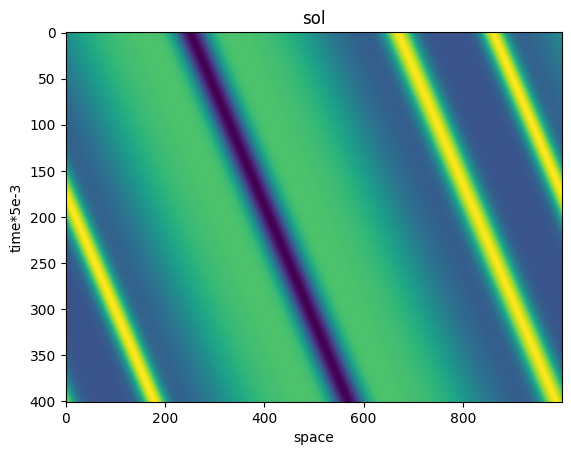

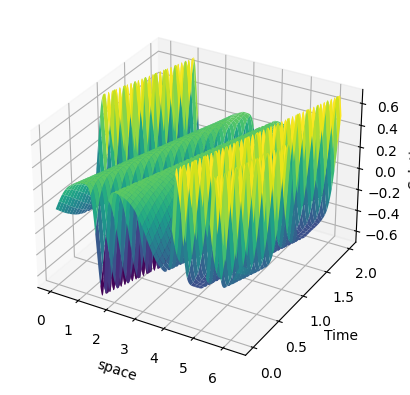

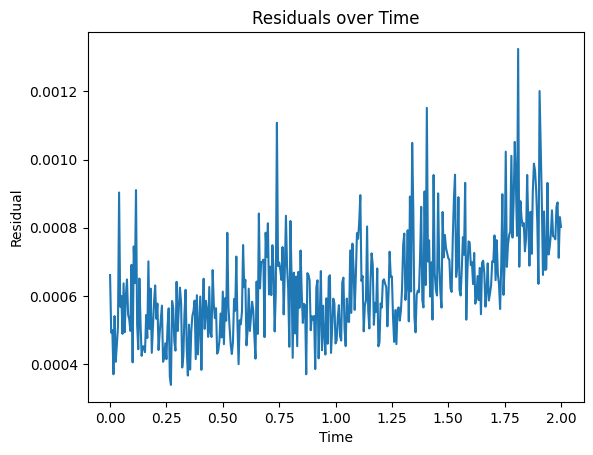

In [2]:

# Plotting
plt.imshow(theta_dot, aspect='auto')
plt.title('sol')
plt.xlabel('space')
plt.ylabel('time*5e-3')
plt.show()

# 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(x_eval, t_eval)
ax.plot_surface(X, Y, theta_dot, cmap='viridis')
ax.set_xlabel('space')
ax.set_ylabel('Time')
ax.set_zlabel('Solution')
plt.show()

# Plot residuals over time
plt.plot(t_eval, residuals)
plt.xlabel('Time')
plt.ylabel('Residual')
plt.title('Residuals over Time')
plt.show()


**reduction in x direction**
$$\min_{\.\theta}\left\|BJ(\theta)\.\theta\;-\;Bf(\theta(t))\right\|_2^2$$
where B is standard Gaussian

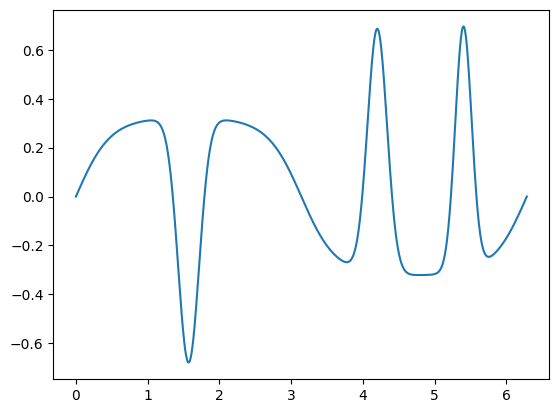

jit complied!
done!
Time: 0.0, Residual: 4.852960410062224e-05
Time: 0.004999999888241291, Residual: 3.436009865254164e-05
Time: 0.009999999776482582, Residual: 4.1691306250868365e-05
Time: 0.014999999664723873, Residual: 4.277475454728119e-05
Time: 0.019999999552965164, Residual: 4.420832920004614e-05
Time: 0.02499999850988388, Residual: 3.602586730266921e-05
Time: 0.029999999329447746, Residual: 6.778065289836377e-05
Time: 0.03500000014901161, Residual: 3.08485577988904e-05
Time: 0.03999999910593033, Residual: 4.462776269065216e-05
Time: 0.044999998062849045, Residual: 3.944747004425153e-05
Time: 0.04999999701976776, Residual: 5.5958316806936637e-05
Time: 0.054999999701976776, Residual: 3.4070766560034826e-05
Time: 0.05999999865889549, Residual: 5.473666897160001e-05
Time: 0.06499999761581421, Residual: 4.47178645117674e-05
Time: 0.07000000029802322, Residual: 4.741406155517325e-05
Time: 0.07499999552965164, Residual: 4.694122253567912e-05
Time: 0.07999999821186066, Residual: 5.48512

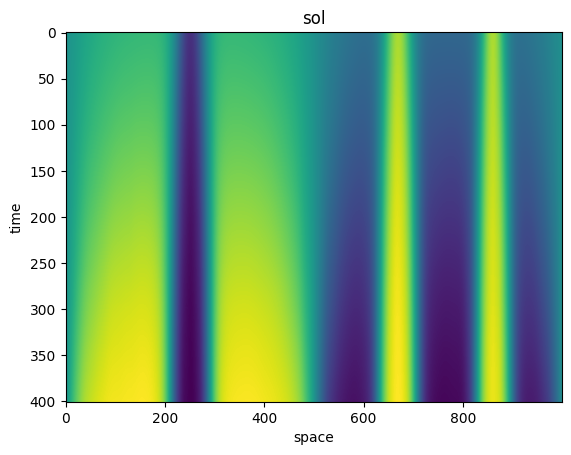

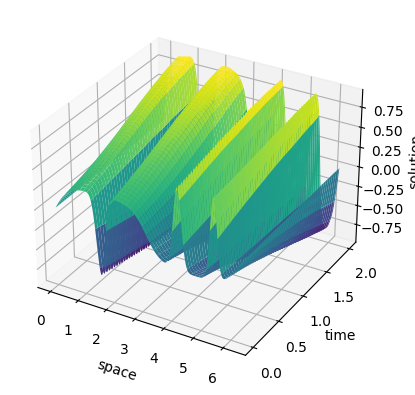

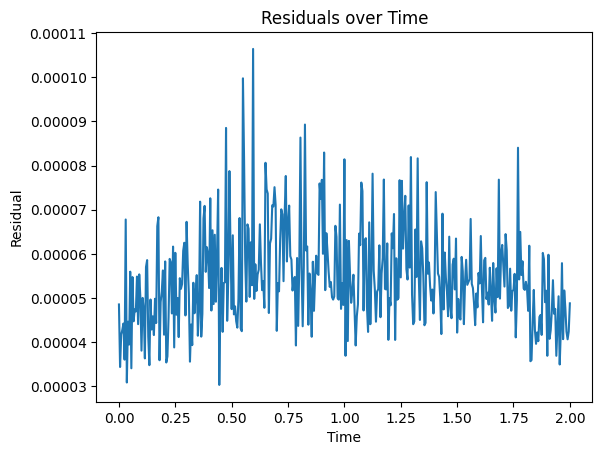

In [8]:
## no sketching. Subsampling by using less rows for B
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import jit, vmap, grad
import jax.flatten_util
from time import time
import pandas as pd
import numpy as np

# High Speed Settings
n_x = 1000  # number of sample points in space
sub_sample = 50  # number of parameters (dots in this case) to randomly sample
dt = 5e-3  # time step 
# set up time and space domain
Tend = 2.0
t_eval = jnp.linspace(0.0, Tend, int(Tend/dt) + 1)

dim = 1
A, B = 0, 2 * jnp.pi
x_eval = jnp.expand_dims(jnp.linspace(A, B, n_x), axis=-1)

from rsng.dnn import build_nn, init_net

key = jax.random.PRNGKey(1)
width = 25
depth = 7
period = 2 * jnp.pi

net = build_nn(width, depth, period)
u_scalar, theta_init, unravel = init_net(net, key, dim)

# used to take gradient and then squeeze
def gradsqz(f, *args, **kwargs):
    return lambda *fargs, **fkwargs: jnp.squeeze(grad(f, *args, **kwargs)(*fargs, **fkwargs))

# batch the function over X points
U = vmap(u_scalar, (None, 0))

# derivative with respect to theta
U_dtheta = vmap(grad(u_scalar), (None, 0))

# first spatial derivative
U_dx = vmap(gradsqz(u_scalar, 1), (None, 0))

# second spatial derivatives
U_ddx = vmap(gradsqz(gradsqz(u_scalar, 1), 1), (None, 0))

# load the parameters which fit initial condition
theta_0 = pd.read_pickle('./rsng/data/theta_init_ac.pkl')
theta_0 = jax.flatten_util.ravel_pytree(theta_0)[0]

# plot initial condition
plt.plot(x_eval, U(theta_0, x_eval))
plt.show()

########### Modified for linear advection equation
# def rhs(t, theta):
#     u = U(theta, x_eval)
#     u_x = U_dx(theta, x_eval)
#     c = lambda t: jnp.sin(5 * t)
#     #c = lambda t :1.0
#     return -c(t) * u_x

# Allen Cahn
def rhs(t, theta):
    "f(theta), dynamics for the allen-cahn equation"
    u = U(theta, x_eval)
    u_xx = U_ddx(theta, x_eval)
    return 5e-3*u_xx+u-u**3


def rhs_reparameterized(t, theta, key):
    key,_= jax.random.split(key)
    J = U_dtheta(theta, x_eval)  # take the gradient with respect to the parameters
    
    B=jax.random.normal(key,(sub_sample,n_x))
    f = rhs(t, theta)
    # apply B
    J = jnp.dot(B, J)
    f = jnp.dot(B, f)
    theta_dot = jnp.linalg.lstsq(J, f, rcond=1e-4)[0]

    residual = jnp.linalg.norm(jnp.dot(J, theta_dot) - f)
    
    # go back into full parameter space, zero for non-sampled columns
    #theta_dot = jnp.zeros(len(theta)).at[S_t].set(theta_dot) 
    return theta_dot, residual

def odeint_rk4(fn, y0, t, key):
    "Adapted from: https://github.com/DifferentiableUniverseInitiative/jax_cosmo/blob/master/jax_cosmo/scipy/ode.py"
    def rk4(carry, t):
        y, t_prev, key = carry
        h = t - t_prev
        key, subkey = jax.random.split(key)

        k1, _ = fn(t_prev, y, subkey)
        k2, _ = fn(t_prev + h / 2, y + h * k1 / 2, subkey)
        k3, _ = fn(t_prev + h / 2, y + h * k2 / 2, subkey)
        k4, _ = fn(t, y + h * k3, subkey)

        y = y + 1.0 / 6.0 * h * (k1 + 2 * k2 + 2 * k3 + k4)
        return (y, t, key), y

    (yf, _, _), y = jax.lax.scan(rk4, (y0, jnp.array(t[0]), key), t)
    return y

def integrate(y0, t):
    return odeint_rk4(rhs_reparameterized, y0, t, key) 

# here we separate compile time from integration time
integrate_complied = jit(integrate).lower(theta_0, t_eval).compile() 
print('jit complied!')
time_start = time()
y = integrate_complied(theta_0, t_eval)
time_end = time()
print('done!')

steps = len(t_eval)
theta_dot = np.zeros((steps, len(x_eval)))
residuals = []

for i in range(steps):
    theta = y[i, :]
    theta_dot[i] = jnp.squeeze(U(theta, x_eval))
    _, residual = rhs_reparameterized(t_eval[i], theta, key)
    residual_value = jax.device_get(residual)
    residuals.append(residual_value)
    print(f"Time: {t_eval[i]}, Residual: {residual_value}")



# Plotting
plt.imshow(theta_dot, aspect='auto')
plt.title('sol')
plt.xlabel('space')
plt.ylabel('time')
plt.show()

# 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(x_eval, t_eval)
ax.plot_surface(X, Y, theta_dot, cmap='viridis')
ax.set_xlabel('space')
ax.set_ylabel('time')
ax.set_zlabel('solution')
plt.show()

# Plot residuals over time
plt.plot(t_eval, residuals)
plt.xlabel('Time')
plt.ylabel('Residual')
plt.title('Residuals over Time')
plt.show()


In [5]:
print('shape of J:',U_dtheta(theta, x_eval).shape)

shape of J: (1000, 3393)


**Previous implementation for linear advection**

In [11]:
import numpy
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import jit, vmap, grad
import jax.flatten_util
from time import time
import pandas as pd
import numpy as np

In [4]:

# High Speed Settings
n_x = 1000  # number of sample points in sapce
sub_sample = 150  # number of paramters to randomly sample
dt = 5e-3  # time step 

In [5]:
# set up time and space domain
Tend = 1.0
t_eval = jnp.linspace(0.0, Tend, int(Tend/dt)+1)

dim = 1
A, B = 0, 2*jnp.pi
x_eval = jnp.expand_dims(jnp.linspace(A, B, n_x), axis=-1)

In [6]:
from rsng.dnn import build_nn, init_net

key = jax.random.PRNGKey(1)
width = 25
depth = 7
period = 2*jnp.pi

net = build_nn(width, depth, period)
u_scalar, theta_init, unravel = init_net(net, key, dim)

In [7]:
# used to take gradient and then squeeze
def gradsqz(f, *args, **kwargs):
    return lambda *fargs, **fkwargs: jnp.squeeze(grad(f, *args, **kwargs)(*fargs, **fkwargs))

# batch the function over X points
U = vmap(u_scalar, (None, 0))

# derivative with repsect to theta
U_dtheta = vmap(grad(u_scalar), (None, 0))

#first spacial derivative
U_dx = vmap(gradsqz(u_scalar, 1), (None, 0))

# second spacial derivatives
U_ddx = vmap(gradsqz(gradsqz(u_scalar, 1), 1), (None, 0))

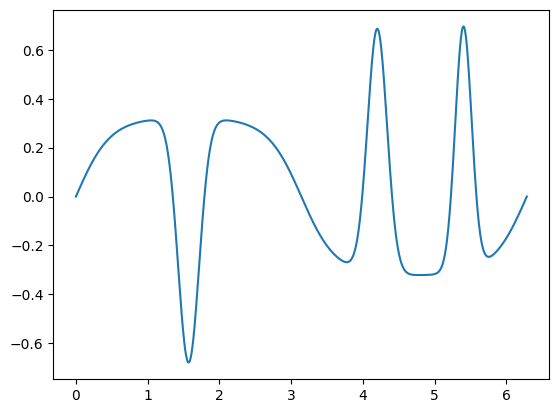

In [8]:
# load the parameters which fit inital condition
theta_0 = pd.read_pickle('./rsng/data/theta_init_ac.pkl')
theta_0 = jax.flatten_util.ravel_pytree(theta_0)[0]
# plot inital condition
plt.plot(x_eval, U(theta_0, x_eval))
plt.show()

In [9]:
########### Modified for linear advection equation
def rhs(t, theta):
    u = U(theta, x_eval)
    u_x = U_dx(theta, x_eval)
    #c =lambda t: jnp.sin(5*t)
    c = lambda t :1.0
    return -c(t)*u_x

def rhs_reparameterized(t, theta, key):

    J = U_dtheta(theta, x_eval)  # take the gradient with respect to the parameters
    #J= jax.random.normal(key, (n_x, len(theta)))   

    S_t = jax.random.choice(key, len(theta), shape=(sub_sample,), replace=False) # create random indices over the columns
    J = jnp.take(J, S_t, axis=1)  # subsample columns

    ## another way to sample is to select random rows instead of columns
    #S_t = jax.random.choice(key, n_x, shape=(sub_sample,), replace=False) # create random indices over the rows
    #J = jnp.take(J, S_t, axis=0)  # subsample rows
    
    f = rhs(t, theta)  # compute f from rhs
    
    # solve least sqaures problem on subsampled gradient
    theta_dot = jnp.linalg.lstsq(J, f, rcond=1e-4)[0]

    # check residual
    residual = jnp.linalg.norm(jnp.dot(J, theta_dot) - f)
    residual_value = jax.device_get(residual)

    # print residual immediately
    print(f"Time: {t}, Residual: {residual_value}")

    print("Residual:", residual)
    
    # go back into full parameter space, zero for non sampled columns
    theta_dot = jnp.zeros(len(theta)).at[S_t].set(theta_dot)
    return theta_dot

In [10]:
def odeint_rk4(fn, y0, t, key):
    "Adapted from: https://github.com/DifferentiableUniverseInitiative/jax_cosmo/blob/master/jax_cosmo/scipy/ode.py"
    def rk4(carry, t):
        y, t_prev, key = carry
        h = t - t_prev
        key, subkey = jax.random.split(key)

        k1 = fn(t_prev, y, subkey)
        k2 = fn(t_prev + h / 2, y + h * k1 / 2, subkey)
        k3 = fn(t_prev + h / 2, y + h * k2 / 2, subkey)
        k4 = fn(t, y + h * k3, subkey)

        y = y + 1.0 / 6.0 * h * (k1 + 2 * k2 + 2 * k3 + k4)
        return (y, t, key), y

    (yf, _, _), y = jax.lax.scan(rk4, (y0, jnp.array(t[0]), key), t)
    return y

In [9]:
# forward Euler integrator
def odeint_euler(fn, y0, t, key):
    def euler(carry, t):
        y, t_prev, key = carry
        h = t - t_prev
        key, subkey = jax.random.split(key)

        y = y + h * fn(t_prev, y, subkey)
        return (y, t, key), y

    (yf, _, _), y = jax.lax.scan(euler, (y0, jnp.array(t[0]), key), t)
    return y


In [13]:
def integrate(y0, t):
    return odeint_rk4(rhs_reparameterized, y0, t, key)

# here we seperate compile time from integration time
integrate_complied = jit(integrate).lower(theta_0, t_eval).compile()
print('jit complied!')
time_start = time()
y = integrate_complied(theta_0, t_eval)
time_end = time()
print('done!')

Time: Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)>, Residual: Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)>
Residual: Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)>
Time: Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)>, Residual: Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)>
Residual: Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)>
Time: Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)>, Residual: Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)>
Residual: Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)>
Time: Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)>, Residual: Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)>
Residual: Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)>
jit complied!
done!


In [12]:
def integrate(y0, t):
    return odeint_rk4(rhs_reparameterized, y0, t, key) 

# here we seperate compile time from integration time
integrate_complied = jit(integrate).lower(theta_0, t_eval).compile() 
print('jit complied!')
time_start = time()
y = integrate_complied(theta_0, t_eval)
time_end = time()
print('done!')

AttributeError: 'function' object has no attribute 'lower'

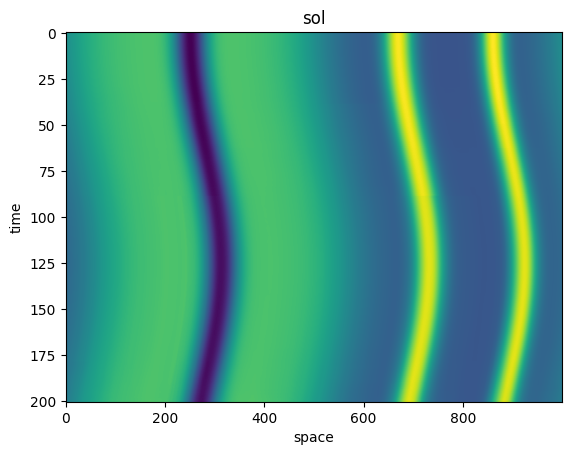

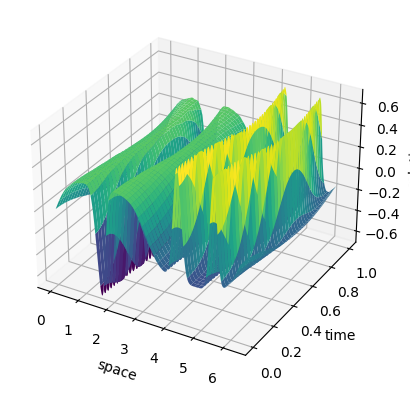

In [11]:

steps = len(t_eval)
theta_dot = np.zeros((steps, len(x_eval)))
for i in range(steps):
    theta = y[i, :]
    theta_dot[i] = jnp.squeeze(U(theta, x_eval))

plt.imshow(theta_dot, aspect='auto')
plt.title('sol')
plt.xlabel('space')
plt.ylabel('time')
plt.show()

# 3d plot
import numpy as np
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(x_eval, t_eval)
ax.plot_surface(X, Y, theta_dot, cmap='viridis')
ax.set_xlabel('space')
ax.set_ylabel('time')
ax.set_zlabel('solution')
plt.show()
